# MODERN PORTFOLIO THEORY & CAPITAL ASSET PRICING MODEL

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [2]:
def get_return_series(ticker, start="2020-01-01", end=None, auto_adjust=False):
    """
    Download adjusted price data for a single ticker and return its daily return Series.
    """
    df = yf.download(ticker, start=start, end=end, auto_adjust=auto_adjust)
    if df.empty:
        raise ValueError(f"No data for {ticker} in {start}–{end}")
    prices = df["Adj Close"] if "Adj Close" in df.columns else df["Close"]
    ret = prices.pct_change().dropna()
    ret.name = ticker
    return ret

In [3]:
def build_returns_dict(tickers, start="2020-01-01", end=None, auto_adjust=False):
    """
    Returns a dict mapping ticker → dict with keys:
      - "returns": pd.Series of daily returns
      - "mean":    float mean(return)
      - "std":     float std(return)
    """
    R = {}
    for t in tickers:
        sr = get_return_series(t, start, end, auto_adjust)
        R[t] = {
            "returns": sr,
            "mean":    sr.mean(),
            "std":     sr.std(ddof=0)
        }
    return R

In [4]:
def compute_mean_vector(returns_dict):
    """
    From the returns_dict, build a pd.Series of means (the μ vector).
    """
    return pd.Series({t: info["mean"] for t, info in returns_dict.items()})

In [5]:
def compute_covariance_matrix(returns_dict):
    """
    Build the variance–covariance matrix Σ.
    Diagonal: Var(r_i),  Off‑diagonal: Cov(r_i, r_j).
    """
    # concat each returns Series into one DataFrame
    df = pd.concat([info["returns"] for info in returns_dict.values()], axis=1)
    df.columns = list(returns_dict.keys())
    return df.cov(ddof=0)


In [6]:
tickers = ["AAPL", "CAT", "JPM"]
Rdict = build_returns_dict(tickers,
                               start="2022-01-01",
                               end="2024-12-31",
                               auto_adjust=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [7]:
# 1) Mean vector μ
mu = compute_mean_vector(Rdict)
print("Mean vector (μ):\n", mu.round(6), "\n")

# 2) Variance–Covariance matrix Σ
Sigma = compute_covariance_matrix(Rdict)
print("Covariance matrix (Σ):\n", Sigma.round(6), "\n")

Mean vector (μ):
 AAPL    Ticker
AAPL    0.000601
dtype: float64
CAT         Ticker
CAT    0.001
dtype: float64
JPM      Ticker
JPM    0.000758
dtype: float64
dtype: object 

Covariance matrix (Σ):
           AAPL       CAT       JPM
AAPL  0.000291  0.000095  0.000094
CAT   0.000095  0.000346  0.000148
JPM   0.000094  0.000148  0.000248 



## Checking results are correct:
Variance

In [8]:
for ticket in Rdict.keys():
      var = Rdict[ticket]["std"]**2
      print(f"{ticket} has a variance of {var}")


AAPL has a variance of Ticker
AAPL    0.000291
dtype: float64
CAT has a variance of Ticker
CAT    0.000346
dtype: float64
JPM has a variance of Ticker
JPM    0.000248
dtype: float64


Covariance

In [9]:
def manual_cov(series_x, series_y):
    """
    Compute population covariance manually between two aligned Series.
    """
    x = series_x.values
    y = series_y.values
    mu_x = np.mean(x)
    mu_y = np.mean(y)
    return np.mean((x - mu_x) * (y - mu_y))


In [10]:
# --- Using your setup ---
aaple_series = Rdict["AAPL"]["returns"]
cat_series = Rdict["CAT"]["returns"]
jpm_series = Rdict["JPM"]["returns"]


# Flatten to Series if needed
if isinstance(aaple_series, pd.DataFrame):
    aaple_series = aaple_series.squeeze()

if isinstance(cat_series, pd.DataFrame):
    cat_series = cat_series.squeeze()

# Align by index
aligned = pd.concat([aaple_series, cat_series], axis=1, join='inner')
aligned.columns = ['AAPL', 'CAT']

# Manual covariance
cov_manual = manual_cov(aligned['AAPL'], aligned['CAT'])
print("Manual Covariance (AAPL, CAT):", cov_manual)


Manual Covariance (AAPL, CAT): 9.539267366852745e-05


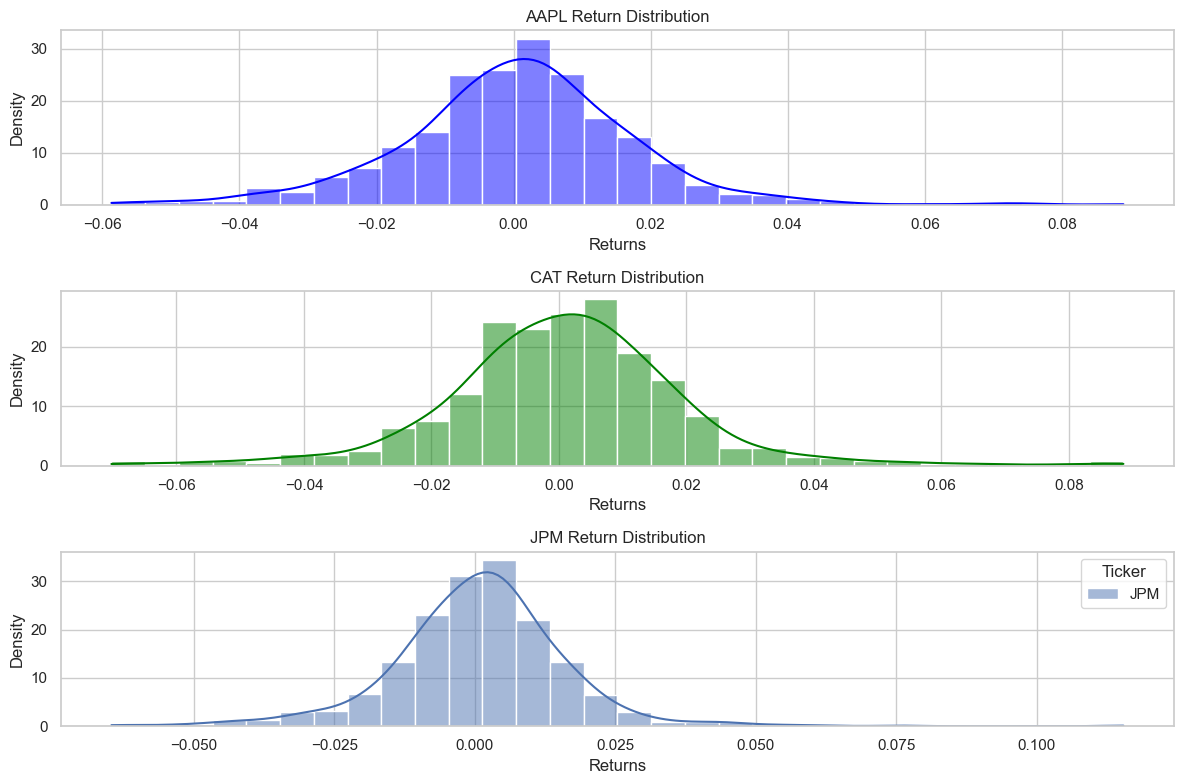

In [11]:

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure for the distribution plots
plt.figure(figsize=(12, 8))

# Plot histogram and KDE for each stock's returns
plt.subplot(3, 1, 1)  # AAPL's returns
sns.histplot(aaple_series, kde=True, bins=30, color="blue", label="AAPL", stat="density")
plt.title("AAPL Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

plt.subplot(3, 1, 2)  # CAT's returns
sns.histplot(cat_series, kde=True, bins=30, color="green", label="CAT", stat="density")
plt.title("CAT Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

plt.subplot(3, 1, 3)  # JPM's returns
sns.histplot(jpm_series, kde=True, bins=30, color="red", label="JPM", stat="density")
plt.title("JPM Return Distribution")
plt.xlabel("Returns")
plt.ylabel("Density")

# Show the plots
plt.tight_layout()
plt.show()





<hr>

In [29]:
values = mu.apply(lambda x: x.values[0])  # Get the numeric value from each Series

In [30]:
mu_matrix = values.values.reshape(-1, 1)  # (n, 1)
mu_matrix

array([[0.00060132],
       [0.00100006],
       [0.0007576 ]])

In [31]:
sigma_matrix = Sigma.to_numpy()

sigma_matrix

array([[2.91215070e-04, 9.53926737e-05, 9.42887406e-05],
       [9.53926737e-05, 3.46481588e-04, 1.47781820e-04],
       [9.42887406e-05, 1.47781820e-04, 2.47842232e-04]])